# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12, 14, 16) # small, medium, big

## Load in our data from last lesson

In [4]:
PATH = "data/bulldozers/"

In [6]:
df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [7]:
def split_vals(a, n): return a[:n], a[n:]

n_valid = 12000
n_trn = len(df_trn) - n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [8]:
def rmse(x,y): return math.sqrt(((x - y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [9]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,2,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,0,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,0,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,2,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,1,988B,...,9,3,221,False,False,False,False,False,False,1186617600


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [10]:
set_rf_samples(50000)

In [11]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20538495115059174, 0.2463770070315658, 0.911839902018488, 0.8915952469905479, 0.8948441803136404]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [12]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:, 0]), np.std(preds[:, 0])

CPU times: user 1.39 s, sys: 32 ms, total: 1.42 s
Wall time: 1.43 s


(9.363183303035791, 0.29177819981067427)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [13]:
def get_preds(t): return t.predict(X_valid)

%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:, 0]), np.std(preds[:, 0])

CPU times: user 100 ms, sys: 100 ms, total: 200 ms
Wall time: 786 ms


(9.363183303035791, 0.29177819981067427)

We can see that different trees are giving different estimates this auction. In order to see how prediction confidence varies, we can add this into our dataset.

You might remember from last lesson that one of the predictors we have is called `Enclosure` and this is an important one as we will see later. Let's start by doing a histogram.

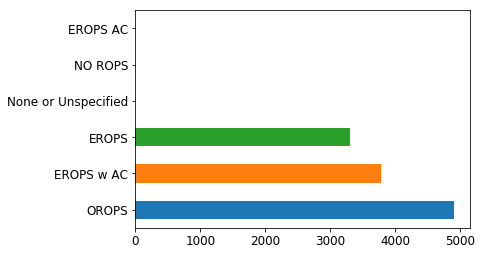

In [14]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh()

In [31]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.842069,0.276354
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.574116,0.262199
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.686715,0.221762


We can already start to learn a little here:

- Prediction and the sale price are close to each other on average (good sign)
- Standard deviation varies a little bit

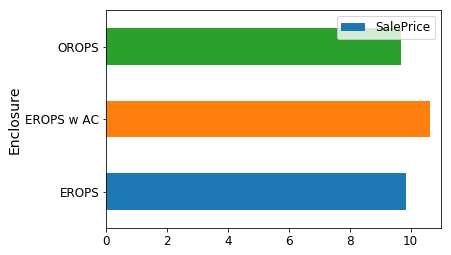

In [32]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0, 11))

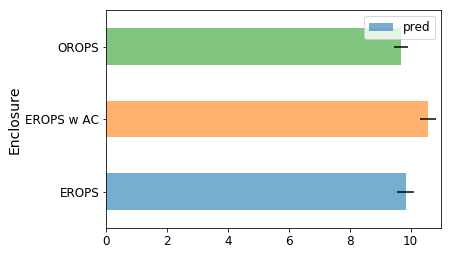

In [33]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0, 11))

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

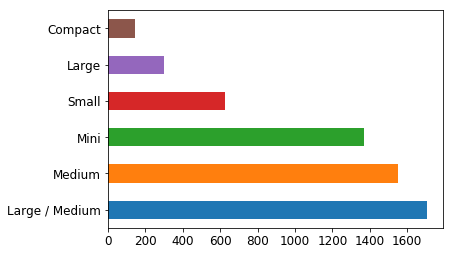

In [34]:
raw_valid.ProductSize.value_counts().plot.barh()

In [35]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.839529,0.328935
Large,10.470589,10.378042,0.348753
Large / Medium,10.691871,10.643605,0.295447
Medium,10.681511,10.622696,0.279759
Mini,9.535147,9.567031,0.255235
Small,10.324448,10.322267,0.313980


In [36]:
(summ.pred_std / summ.pred).sort_values(ascending=False)

ProductSize
Large             0.033605
Compact           0.033430
Small             0.030418
Large / Medium    0.027758
Mini              0.026679
Medium            0.026336
dtype: float64

What this tells us is that product size `Large` and `Compact` , our predictions are less accurate (relatively speaking as a ratio of the total price).

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [37]:
fi = rf_feat_importance(m, df_trn)
fi[:10]

,cols,imp
5,YearMade,0.174338
13,ProductSize,0.100686
37,Coupler_System,0.085942
14,fiProductClassDesc,0.081841
38,Grouser_Tracks,0.072100
2,ModelID,0.051511
63,saleElapsed,0.049223
10,fiSecondaryDesc,0.047323
8,fiModelDesc,0.033645
19,Enclosure,0.031921


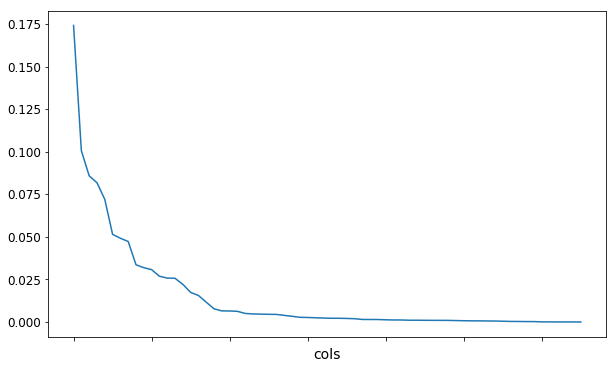

In [38]:
fi.plot('cols', 'imp', figsize=(10, 6), legend=False)

In [39]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12, 7), legend=False)

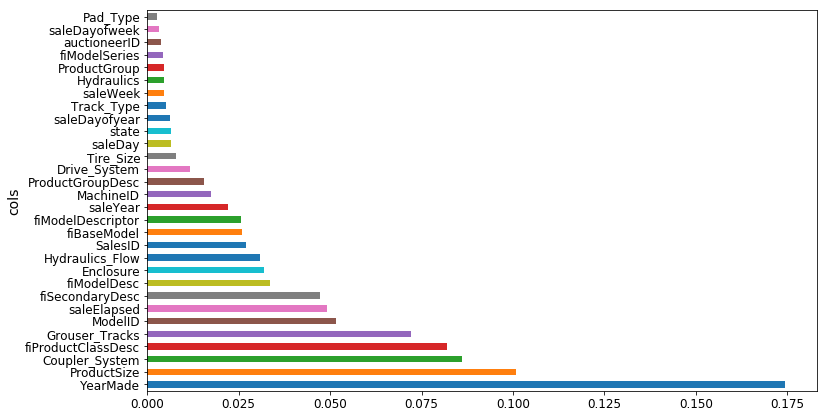

In [40]:
plot_fi(fi[:30])

In [41]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep)

23

In [43]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [46]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.208079761615792, 0.24826694225905, 0.9095112665835299, 0.8899257424863607, 0.8931178000447973]


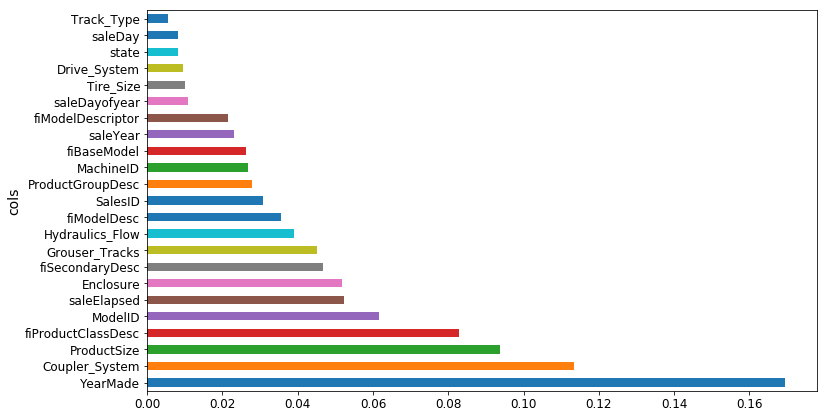

In [47]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi)